In [ ]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=FutureWarning, module=sns.__name__)
warnings.filterwarnings("ignore", category=UserWarning, module=sns.__name__)
sns.set_theme(style="darkgrid")

plt.rcParams.update({
    "axes.labelpad": 10,
    "font.family": "serif",
    "font.size": 10,
    "savefig.bbox": "tight",
})

def read_df(filename):
    mixed = pd.read_csv(filename, na_values=['', ' ', '  ', '   ', '    ', '     '])
    df_obj = mixed.select_dtypes(['object'])
    mixed[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
    mixed["score"] = (mixed["size"] - mixed["blocks"]) / (mixed["size"] - 1)
    return mixed

def read_pso_df(filename):
    df = read_df(filename)
    return df[df["heuristic"] == "pso"]

0.17759856630824372
0.18544973544973545


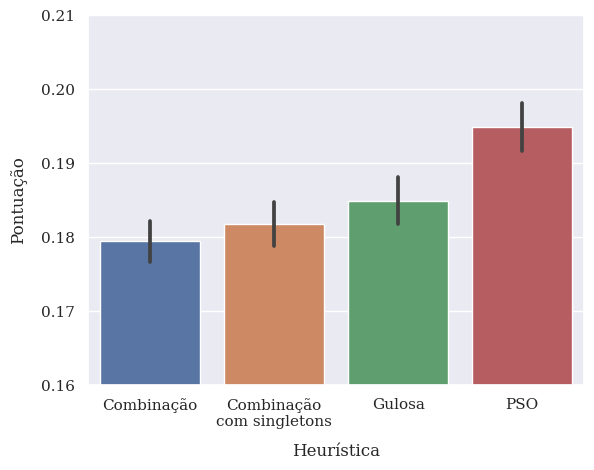

In [ ]:
# BASIC SCORE COMPARISON PLOT FOR A SINGLE FILE

df = read_df("r-5-10-s-5-30-n80-ke0.5-ki0.1-kg0.1-dist1-3-3-3-iter100-part200.csv")
df['logscore'] = np.log(df['score'] + 1)

sns.barplot(data=df, x='heuristic', y='score')
plt.ylim(0.16, 0.21)
plt.xlabel("Heurística")
plt.ylabel("Pontuação")
plt.xticks([0, 1, 2, 3], ["Combinação", "Combinação\ncom singletons", "Gulosa", "PSO"])
plt.savefig("r-5-10-s-5-30-n80-ke0.5-ki0.1-kg0.1-dist1-3-3-3-iter100-part200.pdf")

print(df[df['heuristic'] == 'greedy']['score'].median())
print(df[df['heuristic'] == 'pso']['score'].median())

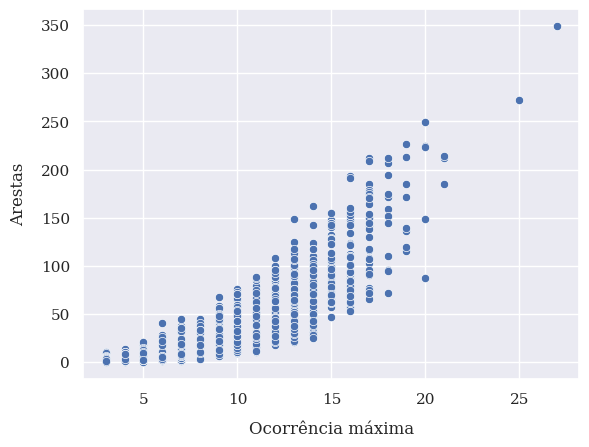

In [ ]:
# PSO EXECUTION TIME

time_edge_pso_df = read_pso_df('r-5-10-s-5-30-n80-ke5.0-ki0.02-kg0.02-dist3-1-1-1-iter1000-part10.csv')

sns.scatterplot(time_edge_pso_df, x="maxRepeat", y="edges")
plt.xlabel("Ocorrência máxima")
plt.ylabel("Arestas")
plt.savefig("arestas-vs-occ.pdf")

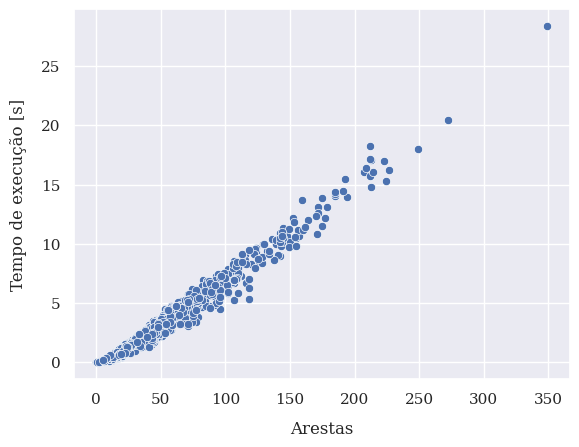

In [ ]:
# sns.scatterplot(time_edge_pso_df, x="edges", y="time")
# plt.xlabel("Arestas")
# plt.ylabel("Tempo de execução [s]")
# plt.savefig("tempo-vs-arestas.pdf")

In [ ]:
# COMPARING PSO RESULTS WITH OTHER HEURISTICS

# mixed = read_df('ke5.0-ki0.02-kg0.02-dist3-1-1-1-iter1000-part10.csv')

# l = mixed['left'].str.strip('[]').str.split(',').str.join(' ')
# r = mixed['right'].str.strip('[]').str.split(',').str.join(' ')
# mixed['pair'] = l + r

# mixed.head()

In [ ]:
def diff_pso(column: pd.Series):
    match column.name:
        case 'heuristic':
            column.iat[-1] = 'best'
            return column
        case 'blocks':
            column = column - column.iat[-1]
            column.iat[-1] = column.iloc[0:3].min()
            return column
        case 'score':
            column = column - column.iat[-1]
            column.iat[-1] = column.iloc[0:3].max()
            return column
        case 'time':
            column = column - column.iat[-1]
            column.iat[-1] = column.iloc[0:3].min()
            return column
        case _:
            return column

df = read_df("r-5-10-s-5-30-n80-ke5.0-ki0.1-kg0.1-dist1-3-3-3-iter100-part200.csv")
l = df['left'].str.strip('[]').str.split(',').str.join(' ')
r = df['right'].str.strip('[]').str.split(',').str.join(' ')
df['pair'] = l + r

pso_diff = df.groupby('pair').transform(diff_pso)
pso_diff = pso_diff[pso_diff["heuristic"] != "best"]
pso_diff.head()

,size,repeats,singles,maxRepeat,edges,heuristic,blocks,score,time,left,right
0,34,9,5,5,6,combine,0,0.000000,-0.590,"[1,1,1,2,0 6,7,6,4,2,9,0,7,13 4,8 4,12,0,10,2 ...","[0,0,9,7,2,2 6,9,2,8 4,1,4,5,0 6,9,4,7,11 2,7,..."
1,34,9,5,5,6,combineS,0,0.000000,-0.591,"[1,1,1,2,0 6,7,6,4,2,9,0,7,13 4,8 4,12,0,10,2 ...","[0,0,9,7,2,2 6,9,2,8 4,1,4,5,0 6,9,4,7,11 2,7,..."
2,34,9,5,5,6,greedy,0,0.000000,-0.588,"[1,1,1,2,0 6,7,6,4,2,9,0,7,13 4,8 4,12,0,10,2 ...","[0,0,9,7,2,2 6,9,2,8 4,1,4,5,0 6,9,4,7,11 2,7,..."
4,76,5,30,11,30,combine,1,-0.013333,-4.527,"[1,14,4,4,6,1 2,12,4 1,1 3,1,0,19,3 2,4,0,27,0...","[6,4,5,0,9,10,4,2 2,1,34,13,0,1,29,7,2,1 3,32,..."
5,76,5,30,11,30,combineS,1,-0.013333,-4.526,"[1,14,4,4,6,1 2,12,4 1,1 3,1,0,19,3 2,4,0,27,0...","[6,4,5,0,9,10,4,2 2,1,34,13,0,1,29,7,2,1 3,32,..."


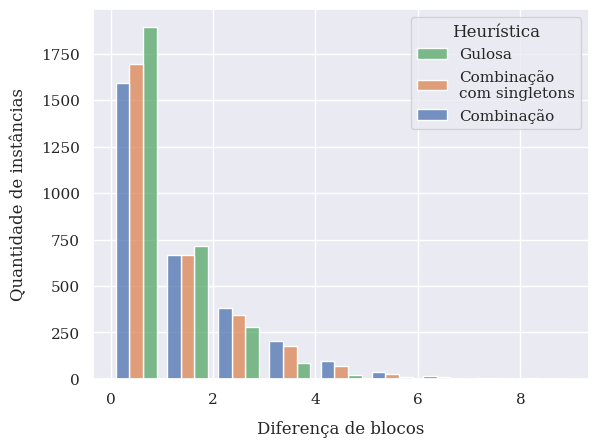

In [ ]:
sns.histplot(pso_diff, x="blocks", hue="heuristic", multiple="dodge", binwidth=1, shrink=0.8)
# plt.xticks(range(0, 8));
plt.xlabel("Diferença de blocos")
plt.ylabel("Quantidade de instâncias")
plt.legend(title='Heurística', labels=["Gulosa", "Combinação\ncom singletons", "Combinação"])
plt.savefig("pso-diff.pdf")

<Axes: xlabel='score', ylabel='Count'>

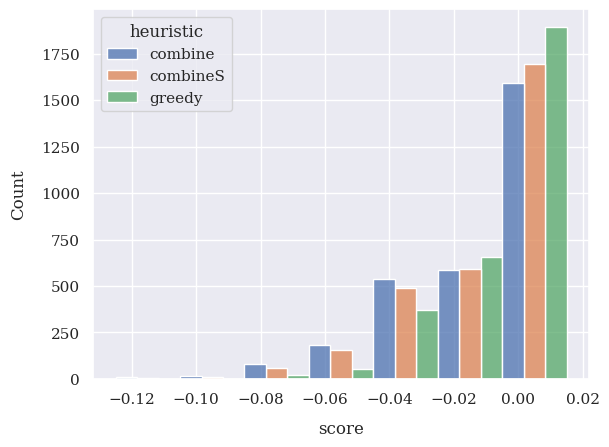

In [ ]:
sns.histplot(pso_diff, x="score", hue="heuristic", multiple="dodge", binwidth=0.02)

0.07629310620341329
0.07629310620341329


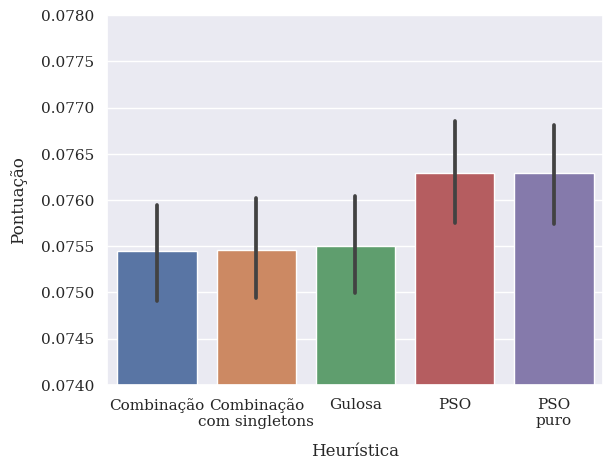

In [ ]:
# COMPARING PSO ALONE, WITH RANDOM STARTING POSITIONS

df = read_df("r50-s-5-10-n220-ke2-ki0.1-kg0.1-dist1-3-3-3-iter100-part200-+pure.csv")

sns.barplot(df, x='heuristic', y='score')
plt.ylim(0.074, 0.078)
plt.xlabel("Heurística")
plt.ylabel("Pontuação")
plt.xticks([0, 1, 2, 3, 4], ["Combinação", "Combinação\ncom singletons", "Gulosa", "PSO", "PSO\npuro"])
plt.savefig("r50-s-5-10-n220-ke2-ki0.1-kg0.1-dist1-3-3-3-iter100-part200-+pure.pdf")

print(df[df['heuristic'] == 'psoPure']['score'].mean())
print(df[df['heuristic'] == 'pso']['score'].mean())

0.20485862544822997
0.1891376294847585


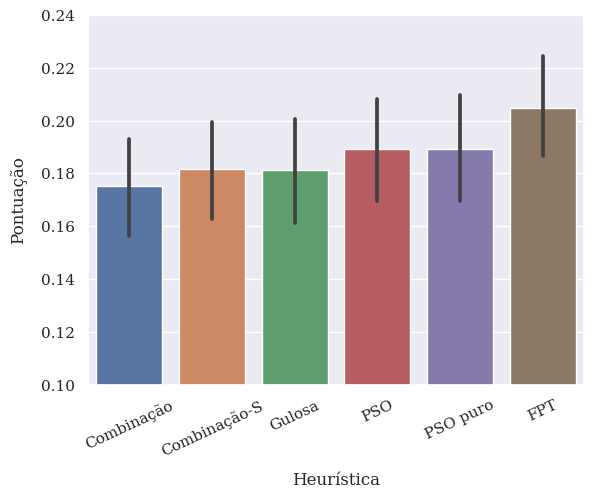

In [ ]:
# COMPARING WITH FPT

df = read_df("FPT2.csv")

sns.barplot(df, x='heuristic', y='score')
plt.ylim(0.10, 0.24)
plt.xlabel("Heurística")
plt.ylabel("Pontuação")
plt.xticks([0, 1, 2, 3, 4, 5], ["Combinação", "Combinação-S", "Gulosa", "PSO", "PSO puro", "FPT"], rotation=25)
plt.savefig("fpt.pdf")

print(df[df['heuristic'] == 'FPT']['score'].mean())
print(df[df['heuristic'] == 'pso']['score'].mean())

In [ ]:
# ANALYZING FIRST BEST PSO ITERATION

# sns.kdeplot(mixed[mixed["heuristic"] == "pso"], x="psoIter", fill=True, clip=(0,None))

In [ ]:
# COMPARISON WITH OTHER ALGORITHMS USING A SEPARATE OUTPUT FILE

# def add_results(df, heuristics, interval):
#     for name in heuristics:
#         heuristics[name]['results'] = []
#         with open(heuristics[name]['filename'], 'r') as file:
#             lines = file.readlines()[:-1]
#             for idx in range(0, len(lines), 2):
#                 size = len(lines[idx].strip().split())
#                 heuristics[name]['results'].append(size)

#     new_df = pd.DataFrame()
#     for name in heuristics:
#         input_columns = ['size', 'repeats', 'singles', 'maxRepeat', 'edges', 'pair']
#         new_data = {col: df.iloc[::interval][col] for col in input_columns}
#         new_data['psoIter'] = ''
#         new_data['time'] = 0
#         new_data['heuristic'] = name
#         new_data['blocks'] = heuristics[name]['results']

#         current = pd.DataFrame(new_data)
#         current['score'] = (current['size'] - current['blocks']) / (current['size'] - 1)
#         new_df = pd.concat([new_df, current])

#     return pd.concat([new_df, df])

# with_other_algs = add_results(
#     mixed,
#     {
#         'g-greedy': {'filename': '31-10-2023-g-greedy.txt'},
#         'g-combine': {'filename': '31-10-2023-g-combine.txt'},
#         'g-soar': {'filename': '31-10-2023-g-soar.txt'},
#         'g-hs': {'filename': '31-10-2023-g-hs.txt'}
#     },
#     4
# )

# with_other_algs.head()

In [ ]:
# sns.barplot(with_other_algs, x="heuristic", y="blocks")